In [1]:
#importing libaries and initialising my network
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import plotly.graph_objects as go
#from plotly.colors import n_colorsy
import I1_cpu_script_16_03_24

torch.cuda.empty_cache()

npts = 1



poly_model = I1_cpu_script_16_03_24.NeuralNetwork(
    number_of_hidden_layers= 3, 
    number_of_auxillary_variable = 3,
    number_of_phase_space_parameters = 3,
    hidden_layer_size = 150,
    output_layer_size = 1,
    activation_function = "tanh",
    batch_size = 50,
    normalisation_coefficient = 120,
    xavier_gain = 1.5
) #tanh  normalisation_coefficient = 120 is max, i chose 8 because it is the standard deviation xavier gain = 1.5
#85000 for dummy_function2 
#batch size = 100000

#poly_model.load_state_dict(torch.load('Glory_to_god_I1_4_layers_100_hidden_tenth_14_03_24_run1.pth'))

torch.set_printoptions(precision=20)



        #return ((input_nodes + 15)/27)  

#foudn this numerically
normalisation_coefficient = poly_model.normalisation_coefficient


0.29417420270727607
0.21213203435596426
0.29900497238329293


In [2]:
def s_normalisation(input_nodes):
    return input_nodes/30# + 29.99)/27
    #return (input_nodes+16.5)/27
    ##return (input_nodes+30.1)/27.2


#functions I may use
def test_function(x1, x2, x3, mH2, s12, s14):
    mt2 = 1
    F1 = mt2 + 2*mt2*(x1 + x2 + x3) + mt2*(x1**2 + x2**2 + x3**2) + 2*mt2*(x2*x3 + x1*x3 + x1*x2) - mH2*(x1*x2 + x2*x3) - x2*s14 - x1*x3*s12
    
    return 1/F1**2

def korobov_test_function(t1, t2, t3, mH2, s12, s14):
    mt2 = 1
    x1 = (3-2*t1)*t1**2
    x2 = (3-2*t2)*t2**2
    x3 = (3-2*t3)*t3**2

    F1 = mt2 + 2*mt2*(x1 + x2 + x3) + mt2*(x1**2 + x2**2 + x3**2) + 2*mt2*(x2*x3 + x1*x3 + x1*x2) - mH2*(x1*x2 + x2*x3) - x2*s14 - x1*x3*s12

    w1 = 6*t1*(1-t1)
    w2 = 6*t2*(1-t2)
    w3 = 6*t3*(1-t3)

    return w1*w2*w3/F1**2



def dummy_functio2_new(t1, t2, t3, mH2, s12, s14):
    x1 = (3-2*t1)*t1**2
    x2 = (3-2*t2)*t2**2
    x3 = (3-2*t3)*t3**2

   
    w1 = 6*t1*(1-t1)
    w2 = 6*t2*(1-t2)
    w3 = 6*t3*(1-t3)

    numerator = s12*s14*x1*x2 + mH2*x3 
    denominator = 0.25*s12*s14 + 0.5*mH2

    dummy_function_tilda = numerator/denominator

    return w1*w2*w3*(dummy_function_tilda)#normalised_value

def dummy_function2(t1, t2, t3, mH2, s12, s14):
    x1 = (3-2*t1)*t1**2
    x2 = (3-2*t2)*t2**2
    x3 = (3-2*t3)*t3**2

    
    w1 = 6*t1*(1-t1)
    w2 = 6*t2*(1-t2)
    w3 = 6*t3*(1-t3)

    numerator = s12*s14*x1*x2 + mH2*x3 

    return w1*w2*w3*(numerator)

def dummy_function_not_in_use(x1,x2,x3,mH2,s12,s14):
    return x1*x2*x3*mH2*s12*s14 

def dummy_function(x1,x2,x3,mH2,s12,s14):
    return x1*x2*x3

def normalised_test_function(x1, x2, x3, mH2, s12, s14):
    normalised_value = korobov_test_function(x1, x2, x3, mH2, s12, s14)/test_function(0.5, 0.5, 0.5, mH2, s12, s14)
    # normalised_value = korobov_test_function(x1, x2, x3, mH2, s12, s14)/test_function(0.5, 0.5, 0.5, mH2, s12, s14)
    return normalised_value



#training tools
loss_function = nn.MSELoss()
optimizer = optim.Adam(poly_model.parameters(), lr =0.001)#
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.9, patience=30, verbose=True)# 0.75

#checking models parameters
#params = poly_model.parameters()
#for param in params:
 #   param.requires_grad = True
#  print(param)


#inputs to the networks for training
lattice_size = poly_model.batch_size #look at batch size
lattice_configurations = 1000#19200#number of s_x combinations
n_repeats = 5#5 #number of times each lattice config is trained
iterations = int(n_repeats*lattice_configurations) 
N_integrands = 8
npts = 10
freq =100#how many points you want in each n_repeat
freq2 = 1
npts_cycle = int(iterations/(freq))
cycle_through = int(iterations)
collection_rate = int(npts_cycle)
npts_cycle2 = int(iterations/(freq2))
collection_rate2 = int(npts_cycle2)
s_npts = 1
i_indication = 0 
validation_set_size = int(poly_model.batch_size*9)  #140000#int(lattice_configurations*lattice_size*0.05) #five percent of the data

#arrays to store information from the training
y_max_array = [] # to find the maximum of the normalised test function in the region of phase-space and feynmann-space
y_min_array = []
y_mean_array = []
y_std_array = []
loss_array = np.zeros(int(freq))
val_loss_array = np.zeros(int(freq))
iteration_array = np.zeros(int(freq))
lr_array = np.zeros(int(freq))
mean_p_value = np.zeros(int(freq)) #to plot mean p over time
mean_r_value = np.zeros(int(freq))
std_p_value = np.zeros(int(freq))
std_r_value = np.zeros(int(freq))
#make these np.zero arrays and fix values to them to increase speed
s_array = []
x_array = []
activation_value_array = [] #6 is because number of hidden layers + 2
d3a_dx3_activation_value_array = []
activation_value_array_std = [] #6 is because number of hidden layers + 2
d3a_dx3_activation_value_array_std = []
weight_array = []
bias_array = []
histogram_log_diff = []
histogram_log_ratio = []

#import data from excel spread sheet, to prepare for forward pass of my NN once the derivative has been trained
file_name_I1 = 'I1_integral_values_excel.xlsx' #integrals from PySecDec validation set
#file_name_I1 = 'DummyFunction2_values_excel.xlsx' #integrals of dummy function2 
#file_name_I1 = 'dummy_function_integrals.xlsx' #integrals of dummy function2 
I1_data = pd.read_excel(file_name_I1, engine = 'openpyxl')
I1_values = I1_data['Column5'] # [Column4] fpr dummy_function_integrals.xlsx #['Column5'] for everything else

#what i was orginially doing
#mH2_values = I1_data['Column1']  
#s12_values = I1_data['Column2']
#s14_values = I1_data['Column3']

#try
# mH2  s12  s14  commment
# 1    2    3    -0.98
# 1    3    2    -1.5   #suspect this one
# 2    1    3    -0.98
# 2    3    1     -0.96
# 3    1    2    #-1.5
# 3    2    1   -0.96


#from 15/03 use this is my best what i've been using
mH2_values = I1_data['Column3']  
s12_values = I1_data['Column1']
s14_values = I1_data['Column2']



normalised_mH2_values = s_normalisation(mH2_values)
normalised_s12_values = s_normalisation(s12_values)
normalised_s14_values = s_normalisation(s14_values)
validation_set_pts = 27000
s_values_t_normalised = torch.tensor([normalised_mH2_values,normalised_s12_values, normalised_s14_values], dtype= torch.float64).T.unsqueeze(1)#torch.rand(27000,1,3)
s_values_t= torch.tensor([mH2_values,s12_values, s14_values], dtype= torch.float64).T.unsqueeze(1)#torch.rand(27000,1,3)


#transfering data from excel spreadsheet to a single tensor so I only need to do one forward pass of the NN for the integration
#normlaised s cooridnates
validation_phase_space_feynmann_params_tensor = torch.empty((validation_set_pts, 8, 6))
validation_phase_space_feynmann_params_tensor[:,:,3:] = s_values_t_normalised
validation_phase_space_feynmann_params_tensor[:,:,:3] = 1 #N11
validation_phase_space_feynmann_params_tensor[:,1,2] = 0  #N011
validation_phase_space_feynmann_params_tensor[:,2,1] = 0  #N101
validation_phase_space_feynmann_params_tensor[:,3,0] = 0  #N110
validation_phase_space_feynmann_params_tensor[:,4:,:3] =0 #N000
validation_phase_space_feynmann_params_tensor[:,5,0] =1 #N100
validation_phase_space_feynmann_params_tensor[:,6,1] =1 #N010
validation_phase_space_feynmann_params_tensor[:,7,2] =1 #N001


#normaliser_centre= dummy_function_not_in_use(rNCentre[:,0],rNCentre[:,1], rNCentre[:,2], rNCentre[:,3], rNCentre[:,4],rNCentre[:,5] ).unsqueeze(1).to(device) 
#making my excel sheet s_inputs into a tensor with a more approachable shape for my forward pass
new_validation_phase_space_feynmann_params_tensor = validation_phase_space_feynmann_params_tensor.view(-1,6).to(torch.float64)#.view(validation_phase_space_feynmann_params_tensor*8, 6)


#unnomrlaised s coordinates
validation_phase_space_feynmann_params_tensor2 = torch.empty((validation_set_pts, 8, 6))
validation_phase_space_feynmann_params_tensor2[:,:,3:] = s_values_t
validation_phase_space_feynmann_params_tensor2[:,:,:3] = 1 #N11
validation_phase_space_feynmann_params_tensor2[:,1,2] = 0  #N011
validation_phase_space_feynmann_params_tensor2[:,2,1] = 0  #N101
validation_phase_space_feynmann_params_tensor2[:,3,0] = 0  #N110
validation_phase_space_feynmann_params_tensor2[:,4:,:3] =0 #N000
validation_phase_space_feynmann_params_tensor2[:,5,0] =1 #N100
validation_phase_space_feynmann_params_tensor2[:,6,1] =1 #N010
validation_phase_space_feynmann_params_tensor2[:,7,2] =1 #N001

#print(f'rNCentre: {rNCentre[::5000, :]}')
print(f's_value_t: {s_values_t.shape}') #[27000, 1, 3]

#new_test_function
normaliser_centre = test_function(0.5,0.5, 0.5, s_values_t[:,0,0], s_values_t[:,0,1], s_values_t[:,0,2] ).unsqueeze(1) 
#test_fucntion
#print(f'normaliser_centre: {normaliser_centre.shape}')
#print(f's_values_t: {s_values_t[:,0,0]}')


#validation set randomly generate so it has a near indentical distribution to my training data, where it is randomly sampled
val_s = 27*torch.rand(validation_set_size, 3).to(torch.float64)-30
val_s_normal = s_normalisation(val_s)
val_x = torch.rand(validation_set_size, 3).to(torch.float64)
val_s_x_mega = torch.cat((val_x, val_s_normal,val_s), dim = 1)
#print(f'val_s_x: {val_s_x.shape}')

#training loop
for epoch in range(iterations):

    #get phase-space and feynman params
    if (epoch) % n_repeats == 0: 
        x_training = torch.rand(lattice_size, 3).to(torch.float64)
        s_training = torch.rand(lattice_size, 3).to(torch.float64)*27 -30
        s_training_normalised = s_normalisation(s_training)
        s_x_mega = torch.cat((x_training, s_training_normalised, s_training), dim = 1)

   #zero gradients
    optimizer.zero_grad()   
      
    #calculate loss, dNN/dx and integrands #normalisation coeficeint bounds the y roughly between 0 and 1
    y = normalised_test_function(s_x_mega[:,0], s_x_mega[:,1], s_x_mega[:,2], s_x_mega[:,6], s_x_mega[:,7], s_x_mega[:,8])/normalisation_coefficient
   
    outputs = poly_model.derivative(s_x_mega[:,:6]) #normalisation coefiic
 #   print(f'outputs: {torch.mean(outputs)}')
  #
   # print(f'outputs: {outputs.shape}')
    #print(f'y:  {y.shape}')
          
    # forward pass

    #if (epoch + 1) % 50 == 0: #10000 
     #   print(f'outputs: {outputs[0][0:6].tolist()}')
      #  print(f'y:       {y[0:6].tolist()}')
    #print(f'y_max {torch.max(y)}')
      
    #y_max_array.append(torch.max(y))
        #y_min_array.append(torch.min(y))
        
   
    loss = loss_function(outputs[0], y)
    
    loss.backward() #    #backward pass

   # for name, param in poly_model.named_parameters():
    #    if param.grad is not None:
     #       print(f'Gradient of {name}:\n{param.grad}')
      #  else:
       #     print(f'No gradient for {name}')

    optimizer.step() #update parameters
    
    

    #check backprop   
   # print(f'Parameter: poly_model.weights_hidden_output, Gradient: {poly_model.weights_hidden_output.grad[93:97]}')
    #print(f'Parameter: poly_model.weights_hidden_hidden, Gradient: {poly_model.weights_hidden_hidden.grad[:,97, 19:23]}')
    #print(f'Parameter: poly_model.weights_input_hidden, Gradient: {poly_model.weights_input_hidden.grad[:, 1:4]}')
   # print(f'Parameter: poly_model.bias_hidden, Gradient: {poly_model.bias_hidden.grad[0:3, 0:3]}')
    #for name, param in poly_model.named_parameters():
        #print(f'gradient: {param.grad.shape}')
        #print(f'Parameter: {name}, Gradient: {param.grad[0][0:6]}')
        #print(f'Parameter: {name}, Gradient: {param.grad[0][0:6]}')
        #Parameter: weights_input_hidden, Gradient: torch.Size([6, 100])
        #Parameter: weights_hidden_hidden, Gradient: torch.Size([2, 100, 100])
        #Parameter: weights_hidden_output, Gradient: torch.Size([100, 1])
        #Parameter: bias_hidden, Gradient: torch.Size([4, 100])#
  
    #validation set 
    poly_model.eval() #
    with torch.no_grad():
        y2 = normalised_test_function(val_s_x_mega[:,0], val_s_x_mega[:,1], val_s_x_mega[:,2], val_s_x_mega[:,6], val_s_x_mega[:,7],val_s_x_mega[:,8] )/normalisation_coefficient
        #print(f's_x2.shape: {s_x2[:,3].shape}')
        #y2 = dummy_function(s_x2[:,0], s_x2[:,1], s_x2[:,2], s_x2[:,3], s_x2[:,4], s_x2[:,5]).to(device) 
        outputs2 = poly_model.derivative(val_s_x_mega[:,:6])

        val_loss = loss_function(outputs2[0], y2)
        #print(val_loss) 
    scheduler.step(val_loss)
    #normally val loss
    poly_model.train()
   
    
    if (epoch + 1) % collection_rate == 0: #10000   
        poly_model.eval()
        with torch.no_grad():
      #      print(f'network integrand: {outputs[0]}')
       #     print(f'true integrand: {y}')
            loss_array[i_indication] = loss
            val_loss_array[i_indication] = val_loss
            iteration_array[i_indication] = epoch + 1
            lr_array[i_indication] = optimizer.param_groups[0]['lr']
         #   print(poly_model.activation_value_collector(x,s))
            activation_intermediates = poly_model.activation_value_collector(val_s_x_mega[:,:6])
        #    print(activation_intermediates)
          #  activation_intermediates = torch.tensor(activation_intermediates, dtype = torch.float64, device = device)
            activation_value_array.append(activation_intermediates[0])
            d3a_dx3_activation_value_array.append(activation_intermediates[1])
            activation_value_array_std.append(activation_intermediates[2])
            d3a_dx3_activation_value_array_std.append(activation_intermediates[3])
            
            
           
            #average p value
            Integral_collection2 = poly_model.forward(new_validation_phase_space_feynmann_params_tensor) #Integral_collection2 : torch.Size([216000, 1])

          #  print(f'new_validation_phase_space_feynmann_params_tensor: {new_validation_phase_space_feynmann_params_tensor.shape}')
           
         #   print(f'Integral_collection2 : {Integral_collection2.shape}')
            
            N111 = Integral_collection2[::8,:] #correct
            N110 = Integral_collection2[1::8,:] #correct
            N101 = Integral_collection2[2::8,:] #correct
            N011 = Integral_collection2[3::8,:] #correct
            N000 = Integral_collection2[4::8,:] #correct,
            N100 = Integral_collection2[5::8,:] #correct
            N010 = Integral_collection2[6::8,:] #correct
            N001 = Integral_collection2[7::8,:] 
          #  print(f'N111.shape: {N111}')
           
            estimate =( N111 - N011 - N101 + N001 - N110 + N010 + N100 -N000)*normaliser_centre*normalisation_coefficient #no normaliser_centre when computing the dummy_fucntion_integrals
            
         #   print(f'estimate: {estimate}')
        #    print(f' s values {N111[1,3:]}') #s values
           # estimate = batch_unnormalisation(estimate)
            #print(f'estimate.shape: {estimate.shape, estimate.dtype}')
             
           
            
            I1_array = np.array(I1_values).reshape(-1,1)
           # print(f'I1_array: {I1_array}')
            #print(f'I1_values: {I1_values}')
            #print(f'I1_array: {I1_array}')
            
            I1_tensor = torch.tensor(I1_array)#*normalisation_coefficient
        #    print(f'I1_tensor: {I1_tensor}')
          #  print(f'I1_tensor: {I1_tensor.shape, I1_tensor.dtype}')
            ratio = torch.log10(abs(estimate)/I1_tensor)

           # gamma = 10**ratio
            #estimate = estimate/gamma
        #    print(f'I1_tensor: {I1_tensor}')
           # print(I1_tensor.shape)
            #print(estimate.shape)
            #print(estimate[21010::1000].T)
          #  print(N111.shape)
         #   print(f'estimate: {estimate}')
            
          #  print(f'ratio: {torch.log10(abs(estimate)/I1_tensor)}')
           # print(f'true:    {I1_tensor[1:3]}')

            log_diff = abs(estimate-I1_tensor)/I1_tensor
            
           # print(f'log_diff: {(abs(estimate-I1_tensor)/I1_tensor)[0:3]}')
            #print(f'log_diff: {log_diff[0:3]}')
            
            

            p_values = torch.log10(abs(estimate-I1_tensor)/I1_tensor) #(27000, ) p = log((e-t)/t)
          #  print(f'p_values: {p_values}')
            
            p_mask = ~torch.isnan(p_values)
          
            AVR_P = torch.mean(p_values[p_mask])
            
            mean_p_value[i_indication] = AVR_P
            std_p_value[i_indication] = torch.std(log_diff)
            mean_r_value[i_indication] = torch.mean(ratio)
            std_r_value[i_indication] = torch.std(ratio)
            #   
            print(f'Epoch  [{epoch+1}/{iterations}]  Loss: {loss},   val_Loss: {val_loss}, p_value: {AVR_P}, p_value_std: {torch.std(log_diff)}, ratio: {torch.mean(ratio)}, ratio_std: {torch.std(ratio)}, estimate: {estimate[10000].item()}, TrueValue: {I1_tensor[10000].item()}, Parameter: poly_model.bias_hidden, Gradient: {poly_model.bias_hidden[0][1]}, poly_model.weights_hidden_hidden, Gradient: {poly_model.weights_hidden_hidden[0][10][10]}')
            #print(f'Parameter: poly_model.bias_hidden, Gradient: {poly_model.bias_hidden}, poly_model.weights_hidden_hidden, Gradient: {poly_model.weights_hidden_hidden[0][97][23]}')
            i_indication = i_indication + 1
        poly_model.train()
    #getting data 
         
    if (epoch + 1) % collection_rate2 == 0: #10000   
        poly_model.eval() 
        with torch.no_grad():
  #         
            Integral_collection = poly_model.forward(new_validation_phase_space_feynmann_params_tensor)
       
            N111 = Integral_collection[::8,:]
            N110 = Integral_collection[1::8,:]
            N101 = Integral_collection[2::8,:]
            N011 = Integral_collection[3::8,:]
            N000 = Integral_collection[4::8,:]
            N100 = Integral_collection[5::8,:]
            N010 = Integral_collection[6::8,:]
            N001 = Integral_collection[7::8,:]
           

            estimate =( N111 - N011 - N101 + N001 - N110 + N010 + N100 -N000)*normaliser_centre*normalisation_coefficient
          #  estimate = batch_unnormalisation(estimate)
            
            I1_array = np.array(I1_values).reshape(-1,1)
            I1_tensor = torch.tensor(I1_array)#*normalisation_coefficient
          
            log_diff = (estimate-I1_tensor)/I1_tensor
            log_ratio = (estimate/I1_tensor)

            p_values = torch.log10(abs(log_diff)) #(27000, ) p = log((e-t)/t)
            r_values = torch.log10(abs(log_ratio))
            #print(p_values)
            filtered_p_values = p_values#[~torch.isinf(p_values)]
            filtered_r_values = r_values[~torch.isinf(r_values)]
          #  print(modded_filtered_p_values)
            histogram_log_diff.append(filtered_p_values)
            histogram_log_ratio.append(filtered_r_values)
        poly_model.train()
         


s_value_t: torch.Size([27000, 1, 3])
Epoch  [50/5000]  Loss: 0.001497798230583509,   val_Loss: 0.005280332904206274, p_value: -0.27194495640055844, p_value_std: 0.41805498638737826, ratio: 0.21980660891890147, ratio_std: 0.11397793429069712, estimate: 0.017658446738079626, TrueValue: 0.009921514635642186, Parameter: poly_model.bias_hidden, Gradient: -0.004527726728883549, poly_model.weights_hidden_hidden, Gradient: -0.1826672084338185
Epoch  [100/5000]  Loss: 0.0008471749261744442,   val_Loss: 0.005123953846700492, p_value: -0.7349368539026917, p_value_std: 0.2356170376519139, ratio: 0.07784724856284526, ratio_std: 0.10122037875743115, estimate: 0.01197847688247772, TrueValue: 0.009921514635642186, Parameter: poly_model.bias_hidden, Gradient: -0.0033120920726291904, poly_model.weights_hidden_hidden, Gradient: -0.18191276936354747
Epoch 00134: reducing learning rate of group 0 to 9.0000e-04.
Epoch  [150/5000]  Loss: 0.0043266990158755845,   val_Loss: 0.005995196832726715, p_value: -0.01

In [3]:
#testing the classes of my derivative network to see if it is the derivative of my network
eps = 0.001
x1 = torch.rand(1)
x2 = torch.rand(1)
x3 = torch.rand(1)
s1 = torch.rand(1)#(torch.rand(1)* 27) -30
s2 = torch.rand(1)#(torch.rand(1)* 27) -30
s3 = torch.rand(1)#(torch.rand(1)* 27) -30
n = 10

x000 = poly_model.forward(torch.tensor([x1, x2, x3, s1,s2,s3]).view(1,-1).to(torch.float64).expand(n,-1))
print(torch.tensor([x1, x2, x3, s1,s2,s3]).view(1,-1).shape)
xeee = poly_model.forward(torch.tensor([x1+eps, x2+eps, x3+eps, s1,s2,s3]).view(1,-1).to(torch.float64).expand(n,-1))

xee0 = poly_model.forward(torch.tensor([x1+eps, x2+eps, x3, s1,s2,s3]).view(1,-1).to(torch.float64).expand(n,-1))
xe0e = poly_model.forward(torch.tensor([x1+eps, x2, x3+eps,  s1,s2,s3]).view(1,-1).to(torch.float64).expand(n,-1))
x0ee = poly_model.forward(torch.tensor([x1, x2+eps, x3+eps,  s1,s2,s3]).view(1,-1).to(torch.float64).expand(n,-1))
x00e = poly_model.forward(torch.tensor([x1, x2, x3+eps,  s1,s2,s3]).view(1,-1).to(torch.float64).expand(n,-1))
x0e0 = poly_model.forward(torch.tensor([x1, x2+eps, x3,  s1,s2,s3]).view(1,-1).to(torch.float64).expand(n,-1))
xe00 = poly_model.forward(torch.tensor([x1+eps, x2, x3,  s1,s2,s3]).view(1,-1).to(torch.float64).expand(n,-1))

#print((x0ee - x0e0 -x00e + x000)) 
#print((xeee - xee0 -xe0e + xe00)) 
#print((xeee - xee0 -xe0e - x0ee + x00e + x0e0 + xe00 - x000))
print((xeee - xee0 -xe0e - x0ee + x00e + x0e0 + xe00 - x000)/(eps**3))
print(poly_model.derivative(torch.tensor([x1, x2, x3, s1,s2,s3]).view(1,-1).to(torch.float64).expand(n,-1)))


torch.Size([1, 6])
tensor([[0.01315200726104137630],
        [0.01315200726104137630],
        [0.01315200726104137630],
        [0.01315200726104137630],
        [0.01315200726104137630],
        [0.01315200726104137630],
        [0.01315200726104137630],
        [0.01315200726104137630],
        [0.01315200726104137630],
        [0.01315200726104137630]], dtype=torch.float64, grad_fn=<DivBackward0>)
tensor([[0.01319592463961632815, 0.01319592463961632815, 0.01319592463961632815,
         0.01319592463961632815, 0.01319592463961632815, 0.01319592463961632815,
         0.01319592463961632815, 0.01319592463961632815, 0.01319592463961632815,
         0.01319592463961632815]], dtype=torch.float64, grad_fn=<MmBackward0>)


1


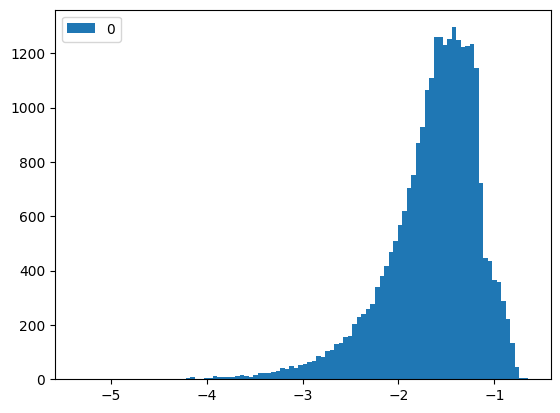

In [4]:

print(len(histogram_log_diff))
#histogram_log_diff = histogram_log_diff.cpu().numpy()
#histogram_log_ratio = histogram_log_ratio.cpu().numpy()

histogram_log_diff_array = [tensor.cpu().numpy() for tensor in histogram_log_diff]
histogram_log_ratio_array = [tensor.cpu().numpy() for tensor in histogram_log_ratio]
#print(histogram_log_diff_array)

#histogram_log_diff = histogram_log_diff.cpu()
#histogram_log_ratio = histogram_log_diff.cpu()
#plt.hist(histogram_log_diff_array[3], bins = 100)
for i in range(0,int(freq2)):
    plt.hist(histogram_log_diff_array[i], bins = 100, label = f'{i}')

plt.legend(loc = 'upper left')
plt.show()


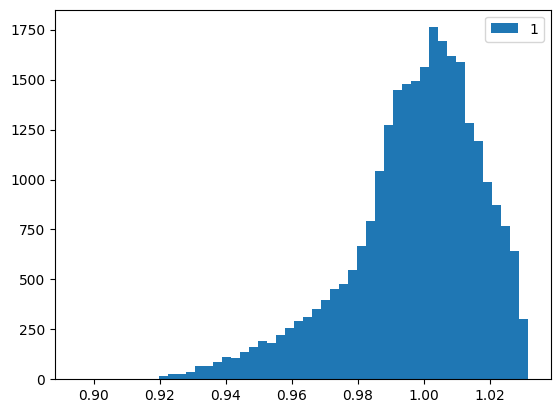

In [5]:
exp_r = np.exp(histogram_log_ratio_array)
#print(exp_r)
for i in range(0,freq2):
   # print()
    plt.hist(exp_r[i], bins = 50, label=f'{i+1}')

plt.legend()
   #plt.hist(histogram_log_ratio_array[i], bins = 50)
#plt.xlim(-0.5,2)


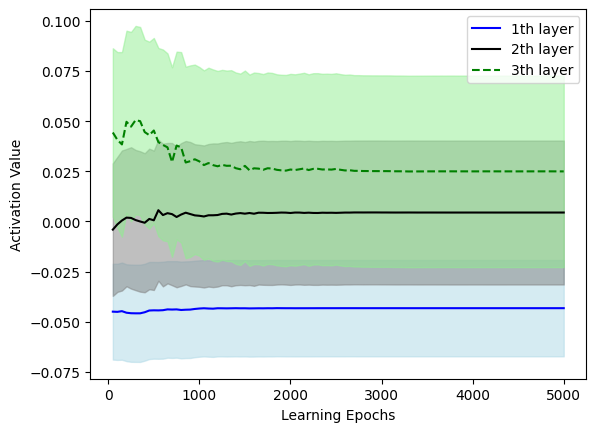

In [6]:
transpose_activation_value_array = list(zip(*activation_value_array))

transpose_activation_value_array_std = list(zip(*activation_value_array_std))
transpose_activation_value_array_std = np.array(transpose_activation_value_array_std)
divisor = 10
noise_filter = 1

transpose_activation_value_array_std = [ x /divisor for x in transpose_activation_value_array_std]

transpose_activation_value_array = np.array(transpose_activation_value_array)
#print(transpose_activation_value_array[1].shape)

y_plus = transpose_activation_value_array + transpose_activation_value_array_std

y_minus = transpose_activation_value_array - transpose_activation_value_array_std

y_plus = y_plus.astype(np.float32)
y_minus = y_minus.astype(np.float32)

y_minus = y_minus[~np.isnan(y_minus)]
y_plus = y_plus[~np.isnan(y_plus)]

y_minus = y_minus.reshape(poly_model.number_of_hidden_layers,-1)
y_plus = y_plus.reshape(poly_model.number_of_hidden_layers,-1)


#print(iteration_array)
#print(iteration_array[::noise_filter])



color_array = ["blue", "black", "green", "red", "yellow"]
color_array2 = ["lightblue", "grey", "lightgreen", "pink", "black"]
linestyle_array = ["-", "-","--", "-.", "-", "_"]


#print(y_minus.reshape(-1,3))
for i in range(0, poly_model.number_of_hidden_layers):
    
    plt.plot(iteration_array[::noise_filter], transpose_activation_value_array[i][::noise_filter], color = color_array[i], linestyle = linestyle_array[i], label = f'{i+1}th layer')
    #plt.errorbar(iteration_array[::noise_filter], transpose_activation_value_array[i][::noise_filter], yerr = transpose_activation_value_array_std[i][::noise_filter], fmt = '-o', capsize = 5, label = f'{i+1}th layer')
    plt.fill_between(iteration_array[::noise_filter], y_minus[i][::noise_filter].flatten(), y_plus[i][::noise_filter].flatten(), color = color_array2[i],alpha = 0.5) #0.5
    #plt.grid(True)
plt.legend(loc= 'best')
plt.ylabel("Activation Value")
plt.xlabel("Learning Epochs")
plt.show()

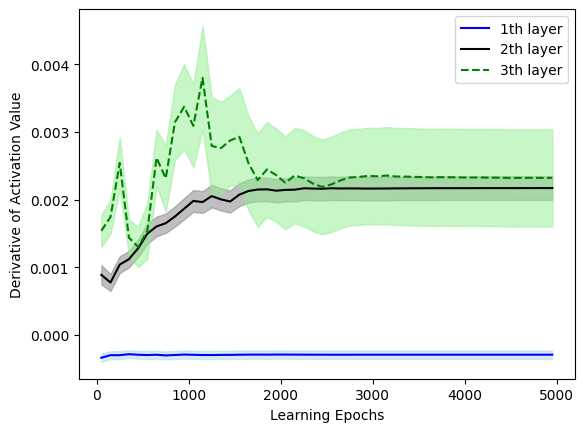

In [7]:
transpose_d3a_dx3_activation_value_array = list(zip(*d3a_dx3_activation_value_array))
transpose_d3a_dx3_activation_value_array_std = list(zip(*d3a_dx3_activation_value_array_std))


transpose_d3a_dx3_activation_value_array_std  = np.array(transpose_d3a_dx3_activation_value_array_std )
divisor = 100
noise_filter = 2

transpose_d3a_dx3_activation_value_array_std  = [ x /divisor for x in transpose_d3a_dx3_activation_value_array_std ]
transpose_d3a_dx3_activation_value_array = np.array(transpose_d3a_dx3_activation_value_array)


y_plus = transpose_d3a_dx3_activation_value_array + transpose_d3a_dx3_activation_value_array_std 

y_minus = transpose_d3a_dx3_activation_value_array - transpose_d3a_dx3_activation_value_array_std 

y_plus = y_plus.astype(np.float32)
y_minus = y_minus.astype(np.float32)

y_minus = y_minus[~np.isnan(y_minus)]
y_plus = y_plus[~np.isnan(y_plus)]

y_minus = y_minus.reshape(poly_model.number_of_hidden_layers,-1)
y_plus = y_plus.reshape(poly_model.number_of_hidden_layers,-1)




color_array = ["blue", "black", "green", "red", "black"]
color_array2 = ["lightblue", "grey", "lightgreen", "pink", "yellow"]
linestyle_array = ["-", "-","--", "-.", "-"]
#print(transpose_activation_value_array)

#print(y_minus.reshape(-1,3))
for i in range(0,poly_model.number_of_hidden_layers):
    
    plt.plot(iteration_array[::noise_filter], transpose_d3a_dx3_activation_value_array[i][::noise_filter], color = color_array[i], linestyle = linestyle_array[i], label = f'{i+1}th layer')
    #plt.errorbar(iteration_array[::noise_filter], transpose_activation_value_array[i][::noise_filter], yerr = transpose_activation_value_array_std[i][::noise_filter], fmt = '-o', capsize = 5, label = f'{i+1}th layer')
    plt.fill_between(iteration_array[::noise_filter], y_minus[i][::noise_filter].flatten(), y_plus[i][::noise_filter].flatten(), color = color_array2[i],alpha = 0.5)
    #plt.grid(True)

plt.legend(loc= 'best')
plt.ylabel("Derivative of Activation Value")
plt.xlabel("Learning Epochs")
plt.show()
    


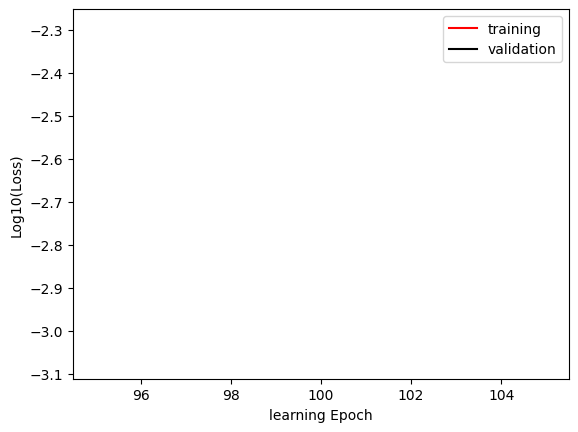

In [8]:
start = 1
endi = freq
end_collect = int(freq2)
plt.plot(iteration_array[start:endi][:end_collect], np.log10(val_loss_array[start:endi][:end_collect]), color = "red")
plt.plot(iteration_array[start:endi][:end_collect], np.log10(loss_array[start:endi][:end_collect]), color = 'black')

#plt.ylim(-0.001, 0.01)
plt.ylabel("Log10(Loss)")
plt.xlabel("learning Epoch")
plt.legend(['training', 'validation'])

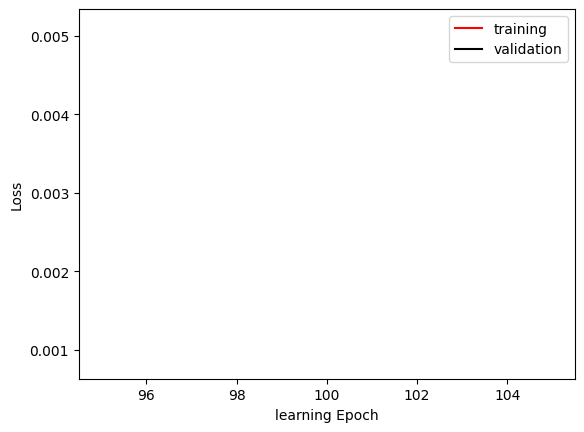

In [9]:

start = 1
endi = freq
end_collect = int(freq2)
plt.plot(iteration_array[start:endi][:end_collect], val_loss_array[start:endi][:end_collect], color = "red")
plt.plot(iteration_array[start:endi][:end_collect], loss_array[start:endi][:end_collect], color = 'black')

#plt.ylim(-0.001, 0.01)
plt.ylabel("Loss")
plt.xlabel("learning Epoch")
plt.legend(['training', 'validation'])

Text(0.5, 0, 'learning Epoch')

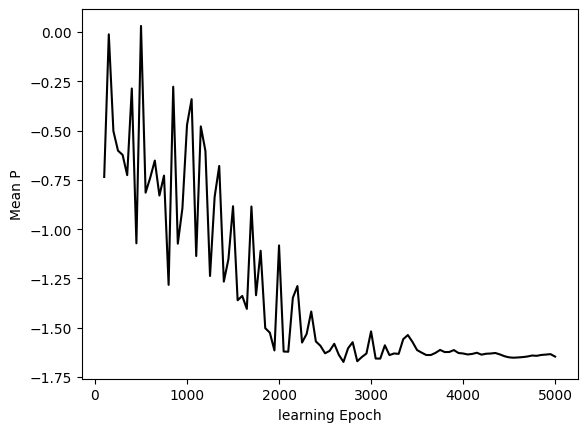

In [10]:
end = int(freq)
start = 1
plt.plot(iteration_array[start:end], mean_p_value[start:end], color = 'black')
#plt.ylim(-0.001, 0.01)
plt.ylabel("Mean P")
plt.xlabel("learning Epoch")

0.001


Text(0.5, 0, 'learning Epoch')

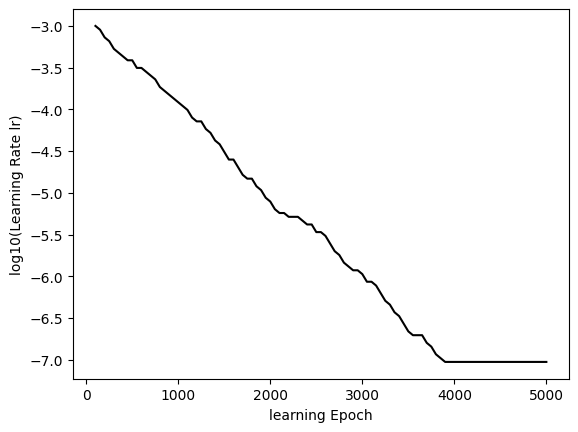

In [11]:
begin = 1
print(str(lr_array[1]))
endh = int(freq)
plt.plot(iteration_array[begin:endh], np.log10(lr_array[begin:endh]), color = 'black')
#plt.ylim(-0.001, 0.01)
plt.ylabel("log10(Learning Rate lr)")
plt.xlabel("learning Epoch")

In [12]:

#16/03/24 batch size = 40000 val_size = 40000 10 layers 80 hidden units

#torch.save(poly_model.state_dict(), '1L_cpu_tanh_2layer_50hidden_branch1_run1.pth')
#torch.save(poly_model.state_dict(), '1L_cpu_tanh_2layer_50hidden_branch1_run2.pth')


#torch.save(poly_model.state_dict(), '1L_cpu_tanh_3layer_50hidden_branch1_run1.pth')
#torch.save(poly_model.state_dict(), '1L_cpu_tanh_3layer_50hidden_branch1_run2.pth')

#torch.save(poly_model.state_dict(), '1L_cpu_tanh_10layer_50hidden_branch1_run2.pth')

#torch.save(poly_model.state_dict(), '1L_cpu_tanh_3layer_100hidden_branch1_run1.pth')
#torch.save(poly_model.state_dict(), '1L_cpu_tanh_3layer_100hidden_branch1_run2.pth')

#torch.save(poly_model.state_dict(), '1L_cpu_tanh_3layer_150hidden_branch1_run1.pth')
torch.save(poly_model.state_dict(), '1L_cpu_tanh_3layer_150hidden_branch1_run2.pth')